# Reevaluate RL

In [2]:
import sys; sys.path.append('../src')
from utils.data import load_data, get_history, top_markets

TIMEFRAME = '1m' #['1h', '1d']
QUOTE     = 'USDT'
LIMIT     = 2000
N         = 10

## Pull in data of interest

In [10]:
markets = top_markets(quote=QUOTE)[:N]
history = get_history(markets, timeframe=TIMEFRAME, limit=LIMIT)
history.head()

,BTC/USDT,ETH/USDT,XRP/USDT,BCH/USDT,BSV/USDT,LTC/USDT,EOS/USDT,XTZ/USDT,LINK/USDT,XLM/USDT
time,,,,,,,,,,
2020-04-09 01:53:00,7298.76,170.19,0.19920,267.69,221.6539,45.90,2.7133,2.1059,3.1426,0.050215
2020-04-09 01:54:00,7301.33,170.66,0.19917,267.92,222.2187,45.93,2.7179,2.1061,3.1473,0.050153
2020-04-09 01:55:00,7304.02,170.71,0.19946,268.28,222.4191,46.01,2.7192,2.1134,3.1515,0.050297
2020-04-09 01:56:00,7313.76,170.98,0.19970,268.67,222.6541,46.06,2.7226,2.1136,3.1619,0.050363
2020-04-09 01:57:00,7315.34,170.97,0.19971,268.89,222.7915,46.09,2.7221,2.1180,3.1639,0.050413


In [23]:
df

,market1,market2,p-value
0,XRP/USDT,XTZ/USDT,0.000325209
1,BTC/USDT,ETH/USDT,0.00176545
2,BTC/USDT,EOS/USDT,0.00229567
3,BSV/USDT,XTZ/USDT,0.00869494
4,ETH/USDT,XTZ/USDT,0.016628
5,LTC/USDT,EOS/USDT,0.0257508
6,XRP/USDT,EOS/USDT,0.0372809
7,BCH/USDT,XTZ/USDT,0.042033
8,EOS/USDT,XTZ/USDT,0.0445675


In [46]:
from cointegration import find_cointegrated_pairs
scores, pvalues, pairs = find_cointegrated_pairs(history)

from IPython.core.display import HTML

def row(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )


def plot_heatmap(pvalues, cutoff=0.98):
    # plot heatmap
    import matplotlib.pyplot as plt
    import seaborn as sns

    fig,ax = plt.subplots(1,1,figsize=[16,12])
    g=sns.heatmap(pvalues, ax=ax, cmap='RdYlGn_r', mask = (pvalues >= cutoff), linewidths=.5, 
                    xticklabels=markets, yticklabels=markets)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize='small')
    g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right', fontsize='small')
    return fig

def data_df(pairs):
    import pandas as pd
    data={'market1': [k[0] for k in pairs.keys()],
          'market2': [k[1] for k in pairs.keys()],
          'p-value': [v[1] for v in pairs.values()]}

    cm  = sns.light_palette("green", as_cmap=True)
    df  = pd.DataFrame(data).sort_values('p-value').reset_index(drop=True)
    df_ = df.copy()
    df  = df.style.background_gradient(subset=['p-value'], cmap=cm)
    df_['pair'] = df_["market1"].map(str) + ' -- ' + df_["market2"]
    return df


def fit_ols(data, market1, market2):
    import statsmodels.api as sm
    import pandas as pd
    x1=data[market1].values
    x2=data[market2].values
    r=sm.OLS(x1,x2).fit().params[0]
    return pd.DataFrame({'x1':x1, 'r*x2':r*x2, 'z':x1 - r*x2}, index=data.index)
    

def plot_trajectory(df_x):
    fig,axs = plt.subplots(2, 1, figsize=[16,8])
    a=sns.lineplot(data=df_x[['x1', 'r*x2']], ax=axs[0])
    b=sns.lineplot(data=df_x[['z']], ax=axs[1], palette=['green'])
    a.figure.canvas.draw(); a.set_xticklabels(a.get_xticklabels(), fontsize='x-small')
    b.figure.canvas.draw(); b.set_xticklabels(b.get_xticklabels(), fontsize='x-small')
    plt.tight_layout()
    
plot_heatmap(pvalues)

,x1,r*x2,z
time,,,
2020-04-09 01:53:00,7298.76,7318.411229,-19.651229
2020-04-09 01:54:00,7301.33,7338.621895,-37.291895
2020-04-09 01:55:00,7304.02,7340.771966,-36.751966
2020-04-09 01:56:00,7313.76,7352.382349,-38.622349
2020-04-09 01:57:00,7315.34,7351.952335,-36.612335
...,...,...,...
2020-04-10 11:08:00,6923.27,6816.584688,106.685312
2020-04-10 11:09:00,6922.88,6814.434617,108.445383
2020-04-10 11:10:00,6922.41,6817.014702,105.395298


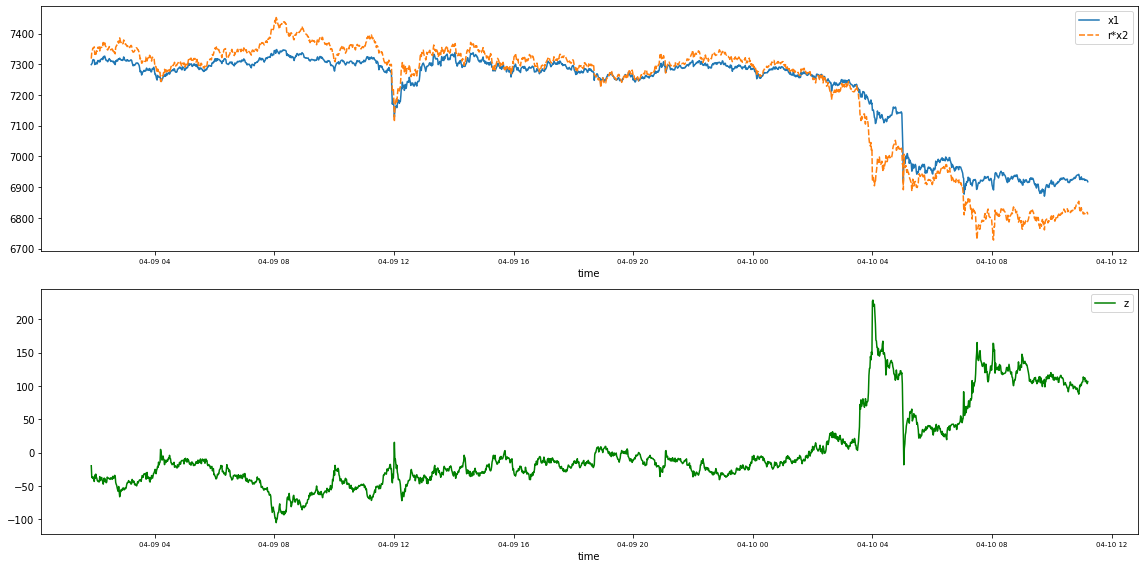

In [52]:
results = fit_ols(history, 'BTC/USDT', 'ETH/USDT')
display(row([results, data_df(pairs)]))
plot_trajectory(results)